<a href="https://colab.research.google.com/github/tackulus/229352_KAGGLE/blob/New/229352_KAGGLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/ECG/ECG.zip;

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWi7o2-t63u9BAoIrWdF6w-nnHOxoP6TMYnBW3aNwPF6ceV1Yn4Bg2s


In [2]:
import numpy as np
import pandas as pd

In [3]:
X_data = np.load('/content/ECG_X_train.npy')
X_data.shape

(14630, 1000, 12)

In [4]:
y_data = np.load('/content/ECG_y_train.npy')
y_data.shape

(14630,)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = \
    train_test_split(X_data, y_data, test_size=.25, random_state=177)

In [6]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

In [7]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

def make_dataset(data, target, batch_size=64):
    dataset = timeseries_dataset_from_array(
        data=data,
        targets=target,
        sequence_length=1,
        sequence_stride=1,
        shuffle=False,
        batch_size=batch_size,
    )

    X, y = next(iter(dataset))
    print(">>", X.shape, y.shape)
    return dataset

train_batch = make_dataset(X_train, y_train)
valid_batch = make_dataset(X_valid, y_valid)

>> (64, 1, 1000, 12) (64, 5)
>> (64, 1, 1000, 12) (64, 5)


## LSTM Encoder-Decoder

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten, LSTM, RepeatVector, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

inps = Input(shape=(1, 1000, 12), name='in')
x = Reshape((1000, 12), name='reshape')(inps)
x = BatchNormalization(axis=1, name='normalize')(x)
encoder = LSTM(units=100, 
                    return_sequences=True,
                    return_state=True,
                    name='encoder')

x, state_h, state_c = encoder(x)

decoder = LSTM(units=100, 
                    return_sequences=True,
                    return_state=True,
                    name='decoder')

x, *_ = decoder(x, [state_h, state_c])

x = Flatten(name='flatten')(x)
x = Dense(2000, activation='relu', name='dense1')(x)
x = Dense( 625, activation='relu', name='dense2')(x)
x = Dense(  25, activation='relu', name='dense3')(x)
outs = Dense(5, activation='softmax', name='out')(x)
model = Model(inputs=inps, outputs=outs)

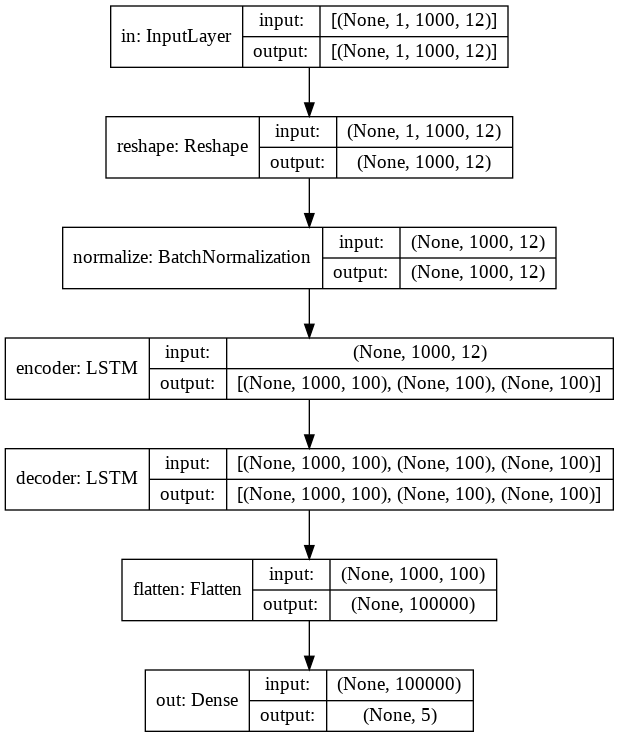

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.fit(train_batch, validation_data=valid_batch, epochs=3)

Epoch 1/3
172/172 [==============================] - 79s 441ms/step - loss: 1.2116 - accuracy: 0.5705 - val_loss: 1.2289 - val_accuracy: 0.5612
Epoch 2/3
172/172 [==============================] - 74s 433ms/step - loss: 1.0598 - accuracy: 0.6125 - val_loss: 1.1082 - val_accuracy: 0.6028
Epoch 3/3
172/172 [==============================] - 74s 431ms/step - loss: 0.9440 - accuracy: 0.6415 - val_loss: 1.1494 - val_accuracy: 0.6186


In [ ]:
X = np.expand_dims(X_valid, axis=1)
model.predict(X)

array([[4.51801457e-02, 5.76802529e-02, 8.74922946e-02, 6.93468809e-01,
        1.16178557e-01],
       [3.68188112e-03, 1.37406467e-02, 9.64622572e-03, 9.54706848e-01,
        1.82244964e-02],
       [2.39199586e-03, 9.73935705e-03, 6.58433139e-03, 9.68004823e-01,
        1.32793905e-02],
       ...,
       [5.89164533e-03, 4.23762435e-03, 1.51466401e-02, 9.42618787e-01,
        3.21052782e-02],
       [5.70928620e-04, 4.05750331e-03, 1.80144748e-03, 9.89825904e-01,
        3.74422502e-03],
       [8.02896097e-02, 6.61428198e-02, 1.42676234e-01, 5.37522376e-01,
        1.73368946e-01]], dtype=float32)

## Convolutional neural network

> https://towardsdatascience.com/time-series-classification-with-deep-learning-d238f0147d6f

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Conv2D, MaxPool2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras.layers import Input, Flatten, Reshape, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

input = Input(shape=(1000,12), name='input')

x = Reshape((1000, 12,1))(input)

x = Conv2D(128, 5, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU(0.2)(x)
x = MaxPool2D()(x)
x = Dropout(0.25)(input)

x = Conv2D(64, 5, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU(0.2)(x)
x = MaxPool2D()(x)
x = Dropout(0.25)(input)

x = Conv2D(64, 5, padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU(0.2)(x)
x = MaxPool2D()(x)
x = Dropout(0.25)(input)

x = Flatten()(x)
x = Dense(128)(x)
x = Dense(64)(x)
output = Dense(5, activation='softmax')(x)
model = Model(inputs=input, outputs=output)

In [40]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1000, 12)]        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 1000, 12)          0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 1000, 12, 1)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 1000, 12, 128)     2048      
_________________________________________________________________
batch_normalization_22 (Batc (None, 1000, 12, 128)     512       
_________________________________________________________________
re_lu_22 (ReLU)              (None, 1000, 12, 128)     0         
_________________________________________________________________
average_pooling2d_17 (Averag (None, 500, 6, 128)       0   

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

earlystopping = EarlyStopping(monitor='val_accuracy',
                              patience=5,
                              restore_best_weights=True)

history = model.fit(X_train[:,:,:,None], y_train, validation_data=(X_valid[:,:,:,None], y_valid),epochs=20,batch_size=64, callbacks=[earlystopping])

In [26]:
model.evaluate(X_valid,y_valid)

115/115 [==============================] - 1s 10ms/step - loss: 0.7068 - accuracy: 0.7685


[0.7068428993225098, 0.7684527039527893]

In [27]:
X_test = np.load('/content/ECG_X_test.npy')
X_test.shape

(1642, 1000, 12)

In [19]:
preds = model.predict(X_test)
y_test = np.argmax(preds, axis=-1)
y_test = pd.DataFrame({'Class': y_test})
y_test.insert(0, 'Patient_ID', y_test.index)
y_test.shape

(1642, 2)

In [20]:
y_test.to_csv('y_test.csv', index=False)

In [21]:
model.save('submission02.h5')